<a href="https://colab.research.google.com/github/Hamxea/Multi-label-Classification/blob/master/Multi_Label_Classification_Using_Wikipedia_Toxic_Comments_Dataset3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Text Classification of Text Document or News


 ### DATASET

Toxic Comment Classification dataset. a multi-label text classfication data consisting of many wikipedia comments which have been labeled by humans according to their relative toxicity comments labels such as "toxic", "severe_toxic", "obscene", "threat", "insult", and  "identity_hate". The dataset has approximately ~160k observation in total, ~125k with zero labels (toxicity) of any type, and approximately ~35k classified in one or more toxicity categories.




*   Dataset Link: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge





#### DATA CHARACTERISTICS (TRAIN DATASET)
* Number of data points	159571
* Number data points of type toxic	15294
* Number data points of type severe_tocic	1595
* Number data points of type obscene	8449
* Number data points of type threat	478
* Number data points of type insult	7877
* Number data points of type identity_hate	1405
* Observations in one or more class	35098
* Unclassified observation	124473


### Import necessary libraries for the experiment

In [0]:
# importing libraries
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

# For custom metrics
import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 


import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt

plt.style.use('seaborn')

import seaborn as sns
from IPython.display import Image

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from nltk.tokenize import word_tokenize
import string
import gensim
import os

sns.set_style("whitegrid")
np.random.seed(0)

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='hamzasharoon', api_key='9le0c8M5GUNRAKyJoIt2')


# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Using TensorFlow backend.


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
Double check with Python 3


### Loading the necessary data files and data Preparation

In [0]:
#from google.colab import files
#uploaded = files.upload()

#from google.colab import drive
#!kaggle competitions download -c Toxic Comment Classification Challenge -p /content/gdrive/My\ Drive/kaggle/Colab Notebooks/Dataset

In [0]:

trace = go.Table(
    header=dict(values=['A Scores', 'B Scores'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['left'] * 5),
    cells=dict(values=[[100, 90, 80, 90],
                       [95, 85, 75, 95]],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['left'] * 5))

layout = dict(width=500, height=300)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = 'styled_table')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~hamzasharoon/0 or inside your plot.ly account where it is named 'styled_table'


In [0]:
#Train data
train = pd.read_csv('train.csv')
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [0]:
#Train data
train = pd.read_csv('train.csv')
train.head(10)

In [0]:
#Test data
df_test = pd.read_csv('test.csv')
df_test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [0]:
df_test_labels = pd.read_csv('test_labels.csv')

df_test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [0]:
test_labels = df_test_labels[(df_test_labels[['toxic','severe_toxic', 'obscene', 'threat', 
                                        'insult', 'identity_hate']] != -1).all(axis=1)]
test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
16,000663aff0fffc80,0,0,0,0,0,0
17,000689dd34e20979,0,0,0,0,0,0
19,000844b52dee5f3f,0,0,0,0,0,0
21,00091c35fa9d0465,1,0,0,0,0,0
22,000968ce11f5ee34,0,0,0,0,0,0


### Merge the df_test and test_labels into 1 dataframe (test)

In [0]:
#Merge the df_test and test_labels into 1 dataframe (test)
test = pd.merge(test_labels, df_test, on='id', how='inner')
test.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding. I think very high...
1,000247e83dcc1211,0,0,0,0,0,0,:Dear god this site is horrible.
2,0002f87b16116a7f,0,0,0,0,0,0,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,0,0,0,0,0,0,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,0,0,0,0,0,0,""" \n\n == Before adding a new product to the l..."
5,000663aff0fffc80,0,0,0,0,0,0,this other one from 1897
6,000689dd34e20979,0,0,0,0,0,0,== Reason for banning throwing == \n\n This ar...
7,000844b52dee5f3f,0,0,0,0,0,0,|blocked]] from editing Wikipedia. |
8,00091c35fa9d0465,1,0,0,0,0,0,"== Arabs are committing genocide in Iraq, but ..."
9,000968ce11f5ee34,0,0,0,0,0,0,Please stop. If you continue to vandalize Wiki...


### Number of records in the train and test data

In [0]:
print("Train data shape", train.shape)
print("Test data shape", test.shape)

Train data shape (159571, 8)
Test data shape (63930, 8)


In [0]:
# check that there are no missing values in either training set
print('The dataset has', train.isna().sum().sum(), 'missing values in train data.')
print('The dataset has', test.isna().sum().sum(), 'missing values in test data.')

# check if there are any duplicates
print('The dataset has', train.duplicated().sum(), 'duplicates in train data.')
print('The dataset has', test.duplicated().sum(), 'duplicates in test data.')

The dataset has 0 missing values in train data.
The dataset has 0 missing values in test data.
The dataset has 0 duplicates in train data.
The dataset has 0 duplicates in test data.


### CORRELATION BETWEEN DATA LABELS

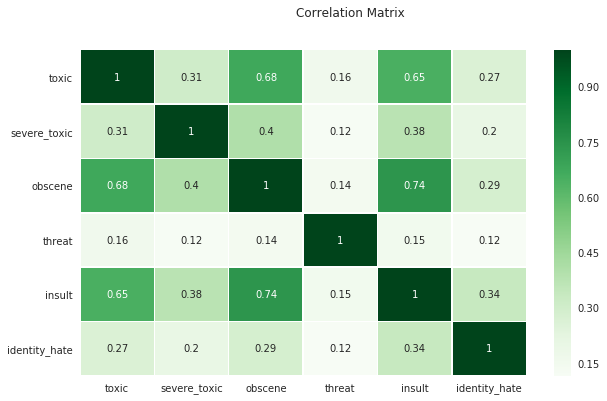

In [0]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix')
sns.heatmap(train.corr(), annot=True, cmap="Greens", linewidths=.5, ax=ax);

The correlation figure below shows that Toxic" comments are clearly correlated with both "obscene" and "insult" comments. Interestingly, "toxic" and "severe_toxic" are only weakly correlated. While we can also observe that, "Obscene" comments and "insult" comments are also highly correlated, which makes perfect sense.

### DATA PREPROCESSING
Deep Neural Networks input layers make use of input variables to feed the network for training the model. But in this task (experiment), we're dealing with words text. How do we represent these words in order to feed our model?

In our experiment, we used densed representation of those text (comments) and their semanticity together. The advantage of using this approach is the best way for fitting neural networks onto a text data (as in our case), as well as less memory usage compared to other sparse representation approaches.


#### Word Embedding
Two ways to feed embeddings to neural networks:
   * Using your own word embeddings by training
   * Using pre-trained embedding (e.g Word2vec, lad2vec, Glove etc)
   


In [0]:
#Convert text to vectors using keras preprocessing library tools

X_train = train["comment_text"].values
X_test  = test["comment_text"].values

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values






For the first embedding, we used keras preprocessing (Text Preprocessing) libraries. This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf

In [0]:
num_words = 20000 #Max. workds to use per toxic comment
max_features = 200000 #Max. number of unique words in embeddinbg vector
max_len = 200 #Max. number of words per toxic comment to be use
embedding_dims = 128 #embedding vector output dimension 
num_epochs = 25 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.1
batch_size2 = 256 #(before 32)The **batch size** is the number of training examples in one forward/backward pass.
                  # In general, larger batch sizes result in faster progress in training, but don't always converge as quickly. 
                  #Smaller batch sizes train slower, but can converge faster. And the higher the batch size, the more memory space you’ll need.

In [0]:
#toxic comments Tokenization
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X_train))

#Convert tokenized toxic commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = sequence.pad_sequences(X_train, max_len)
X_test  = sequence.pad_sequences(X_test,  max_len)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (159571, 200)
X_test shape:  (63930, 200)


### Train, Validation, Test Splits
#### Train Data: 
The sample data used to fit the model.
#### Validation Data: 
The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters.

#### Test Data:
The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset

The test set is generally what is used to evaluate competing models (For example on many Kaggle competitions, the validation set is released initially along with the training set and the actual test set is only released when the competition is about to close, and it is the result of the the model on the Test set that decides the winner).


#### Our Experiment Splits Ratio
Split ratio on most of the experimental datasets depends mainly on two (2) things: The number of samples in the data, and the actual model you are training.

It's always good to splits in the raio of (60%:20%:20%) in terms of (Train:Validation:Test) when you have 1 dataset. But thanks to kaggle competition spits of Train dataset and Test dataset. Now, we need to compute only the validation accuracy.


In our experiment, we keep aside the Test set dataset, and used keras "validation_split" function in order to choose 80% of the Train dataset to be the actual Train set and the remaining (20%) to be the Validation set. The model is then iteratively trained and validated on these different sets.

The Train dataset consists of (159571 samples), so when to split it into train and validaton. we have train split (0.8 of train dataset) =  127657  samples, while the validation split(0.2 of Train dataset) = 31914 samples. 

Lastly, the test dataset consists of 63930 samples, therefore, we use all the samples as our test split.



## METHODS (NN, CNN, RNN, LSTM)

#### We used early callback functionality that allows you to specify the performance measure to monitor, the trigger, and once triggered. It will stop the training process.

In [0]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)

#### Using Precision, Recall, F1-Measure, AUC, mean etc evaluaiton metrics to evaluate our model

In [0]:
#Import necessary libraries
4# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  #Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def auroc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)


fscore = f1score = fmeasure

### 1) Neural Network (NN)

In [0]:
nn_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dropout(0.3),
    Dense(6, activation = 'sigmoid')
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Compile the NN model

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)


nn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### Visualize the Orchestrated NN Architecture

In [0]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 25,606,756
Trainable params: 25,606,756
Non-trainable params: 0
_________________________________________________________________


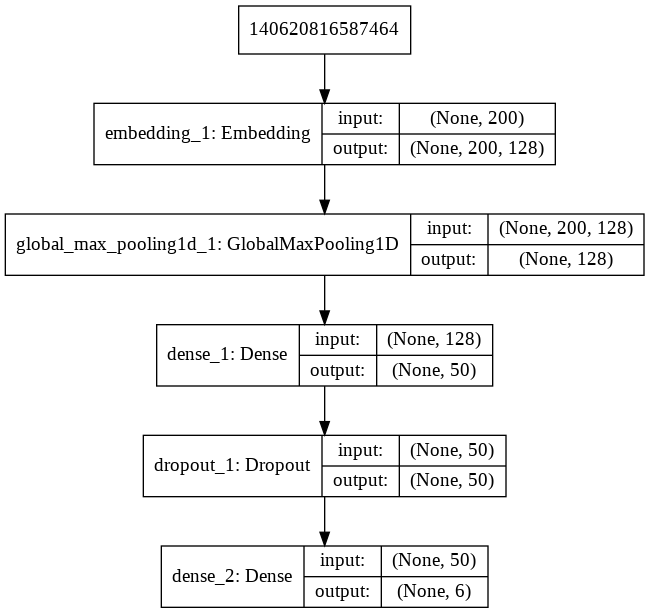

In [0]:
#plot the nn_model architecture

plot_model(nn_model, to_file='nn_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='nn_model_plot.png')

In [0]:
nn_model_fit = nn_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Instructions for updating:
Use tf.cast instead.
Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 15s 102us/step - loss: 0.0839 - acc: 0.9740 - mean_pred: 0.0414 - fmeasure: 0.4963 - precision: 0.6845 - auroc: 0.8427 - recall: 0.4194 - val_loss: 0.0536 - val_acc: 0.9801 - val_mean_pred: 0.0329 - val_fmeasure: 0.6700 - val_precision: 0.8537 - val_auroc: 0.9402 - val_recall: 0.5562
Epoch 2/25
143613/143613 [==============================] - 13s 91us/step - loss: 0.0478 - acc: 0.9821 - mean_pred: 0.0367 - fmeasure: 0.7204 - precision: 0.8242 - auroc: 0.9561 - recall: 0.6455 - val_loss: 0.0515 - val_acc: 0.9813 - val_mean_pred: 0.0394 - val_fmeasure: 0.7209 - val_precision: 0.7945 - val_auroc: 0.9645 - val_recall: 0.6672
Epoch 3/25
143613/143613 [==============================] - 13s 90us/step - loss: 0.0432 - acc: 0.9832 - mean_pred: 0.0366 - fmeasure: 0.7429 - precision: 0.8287 - auroc: 0.9693 - recall: 0.6790 - val_loss: 0.051

### Evaluate the NN accuracy of our trained model

In [0]:
nn_train_score = nn_model.evaluate(X_train, y_train, batch_size = batch_size2, verbose = 1)
print('Train loss:', nn_train_score[0])
print('Train accuracy:', nn_train_score[1])

159571/159571 [==============================] - 1s 9us/step
Train loss: 0.026928757336431783
Train accuracy: 0.9891103672626856


### Evaluate the NN accuracy base on the test dataset

In [0]:
nn_test_score = nn_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', nn_test_score[0])
print('Test Accuracy:', nn_test_score[1])

63930/63930 [==============================] - 1s 10us/step
Test Loss: 0.09506834455611801
Test Accuracy: 0.9667996135523262


In [0]:
#Predicting......
print('Predicting....')
y_pred = nn_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 0s 5us/step


### Plot Training & Validation Accuracy with the Loss values of the NN Model

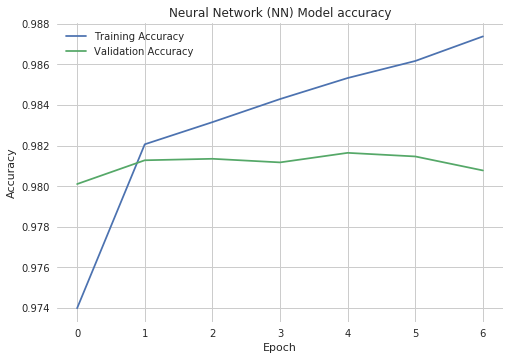

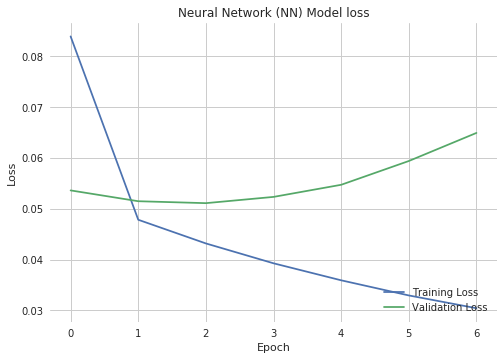

In [0]:
# Plot training & validation accuracy values
plt.plot(nn_model_fit.history['acc'])
plt.plot(nn_model_fit.history['val_acc'])
plt.title('Neural Network (NN) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(nn_model_fit.history['loss'])
plt.plot(nn_model_fit.history['val_loss'])
plt.title('Neural Network (NN) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 2) Convolutional Neural Network (CNN)

In [0]:
CNN_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

CNN_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

### Visualize the Orchestrated CNN MODEL Architecture

In [0]:
CNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 100)          51300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 100)          400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
__________

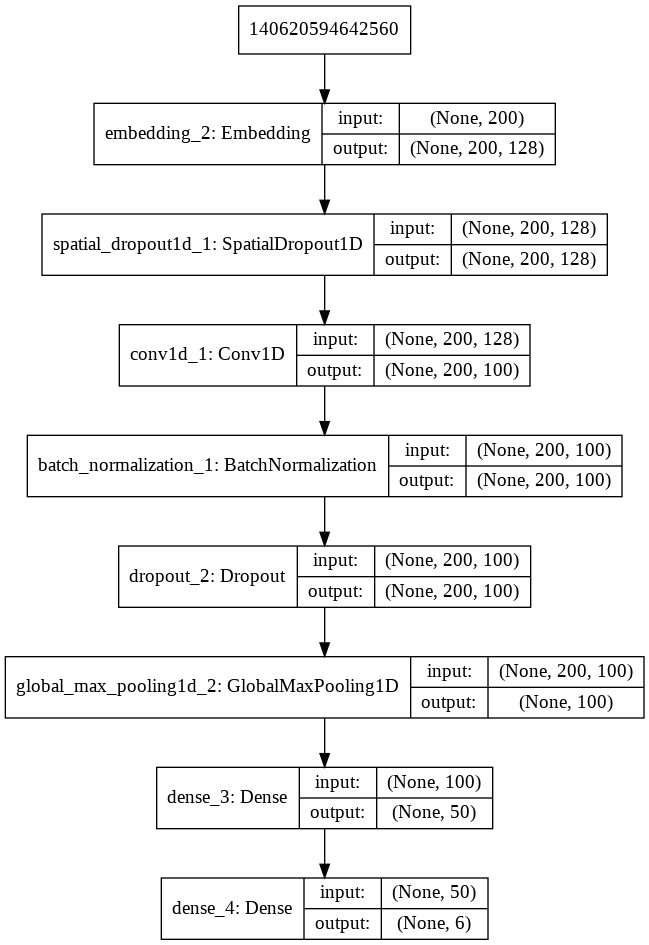

In [0]:
#plot the CNN model architecture

plot_model(CNN_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_model_plot.png')

In [0]:
CNN_model_fit = CNN_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 25s 171us/step - loss: 0.0823 - acc: 0.9753 - mean_pred: 0.0391 - fmeasure: 0.6123 - precision: 0.7474 - auroc: 0.8939 - recall: 0.5390 - val_loss: 0.0708 - val_acc: 0.9795 - val_mean_pred: 0.0559 - val_fmeasure: 0.6650 - val_precision: 0.8258 - val_auroc: 0.9429 - val_recall: 0.5642
Epoch 2/25
143613/143613 [==============================] - 20s 143us/step - loss: 0.0521 - acc: 0.9813 - mean_pred: 0.0371 - fmeasure: 0.7113 - precision: 0.8103 - auroc: 0.9539 - recall: 0.6443 - val_loss: 0.0605 - val_acc: 0.9807 - val_mean_pred: 0.0495 - val_fmeasure: 0.7016 - val_precision: 0.8191 - val_auroc: 0.9610 - val_recall: 0.6185
Epoch 3/25
143613/143613 [==============================] - 21s 143us/step - loss: 0.0464 - acc: 0.9826 - mean_pred: 0.0367 - fmeasure: 0.7358 - precision: 0.8191 - auroc: 0.9657 - recall: 0.6786 - val_loss: 0.0574 - val_acc: 0.9809 - val_mean_pred: 0.0484 - 

### Evaluate the CNN Model accuracy of our trained model

In [0]:
CNN_train_score = CNN_model.evaluate(X_train, y_train, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_train_score[0])
print('Train accuracy:', CNN_train_score[1])

159571/159571 [==============================] - 4s 24us/step
Train loss: 0.029356360799141185
Train accuracy: 0.9888952065470099


### Evaluate the CNN accuracy base our test samples

In [0]:
CNN_test_score = CNN_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_test_score[0])
print('Test Accuracy:', CNN_test_score[1])

63930/63930 [==============================] - 1s 23us/step
Test Loss: 0.08462238075395491
Test Accuracy: 0.9660618302483859


In [0]:
#Predicting......
print('Predicting....')
y_pred = CNN_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 1s 21us/step


### Plot Training & Validation Accuracy with the Loss values of the CNN Model

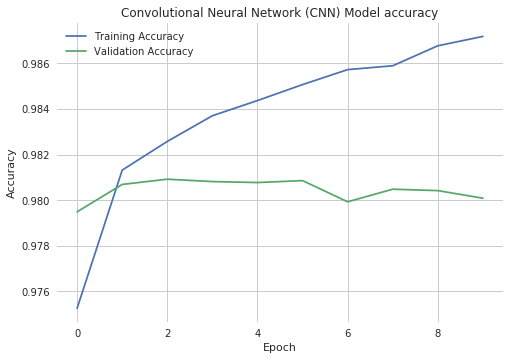

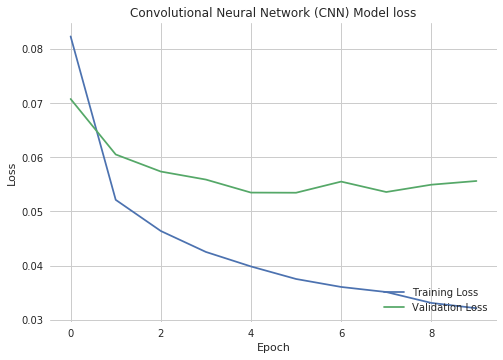

In [0]:
# Plot training & validation accuracy values
plt.plot(CNN_model_fit.history['acc'])
plt.plot(CNN_model_fit.history['val_acc'])
plt.title('Convolutional Neural Network (CNN) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_model_fit.history['loss'])
plt.plot(CNN_model_fit.history['val_loss'])
plt.title('Convolutional Neural Network (CNN) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 3) Recurrent Neural Networks (RNNs)

In [0]:
RNN_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

RNN_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

### Visualize the Orchestrated RNN MODEL Architecture

In [0]:
RNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 50)           30800     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 50)           200       
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
__________

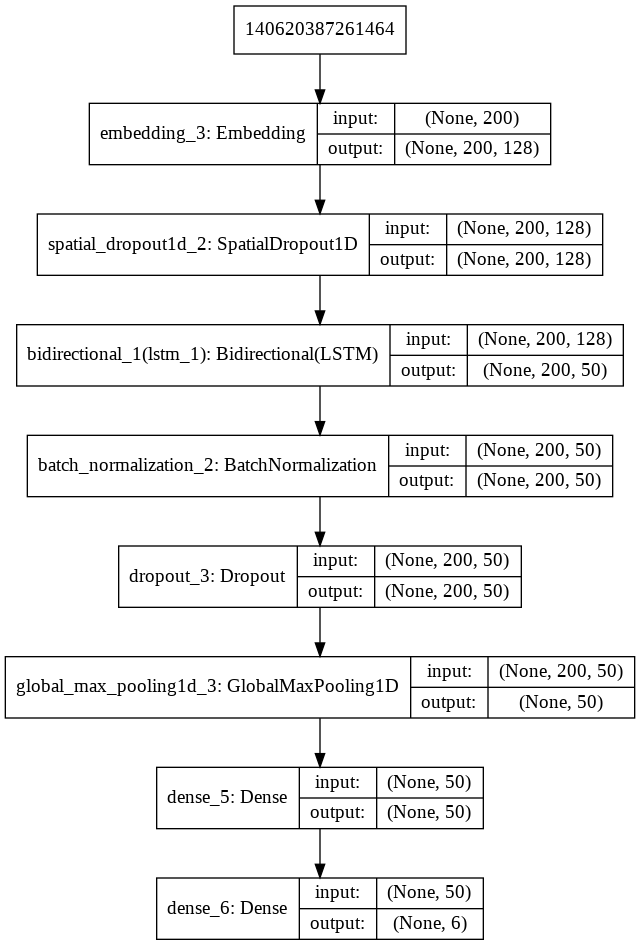

In [0]:
#plot the RNN model architecture

plot_model(RNN_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_model_plot.png')

In [0]:
RNN_model_fit = RNN_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 364s 3ms/step - loss: 0.0642 - acc: 0.9779 - mean_pred: 0.0377 - fmeasure: 0.6438 - precision: 0.7595 - auroc: 0.9270 - recall: 0.5732 - val_loss: 0.0707 - val_acc: 0.9812 - val_mean_pred: 0.0635 - val_fmeasure: 0.7279 - val_precision: 0.7765 - val_auroc: 0.9641 - val_recall: 0.6912
Epoch 2/25
143613/143613 [==============================] - 364s 3ms/step - loss: 0.0477 - acc: 0.9825 - mean_pred: 0.0367 - fmeasure: 0.7338 - precision: 0.8168 - auroc: 0.9694 - recall: 0.6725 - val_loss: 0.0590 - val_acc: 0.9818 - val_mean_pred: 0.0485 - val_fmeasure: 0.7089 - val_precision: 0.8516 - val_auroc: 0.9730 - val_recall: 0.6121
Epoch 3/25
143613/143613 [==============================] - 364s 3ms/step - loss: 0.0435 - acc: 0.9835 - mean_pred: 0.0366 - fmeasure: 0.7510 - precision: 0.8278 - auroc: 0.9755 - recall: 0.6927 - val_loss: 0.0580 - val_acc: 0.9816 - val_mean_pred: 0.0540 - val

### Evaluate the RNN Model accuracy of our trained model

In [0]:
RNN_train_score = RNN_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', RNN_train_score[0])
print('Train Accuracy:', RNN_train_score[1])

159571/159571 [==============================] - 152s 951us/step
Train Loss: 0.04103009784418444
Train Accuracy: 0.9860375474048254


### Evaluate the RNN accuracy base our test samples

In [0]:
RNN_test_score = RNN_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', RNN_test_score[0])
print('Test Accuracy:', RNN_test_score[1])

63930/63930 [==============================] - 60s 939us/step
Test Loss: 0.08083620981703561
Test Accuracy: 0.9674800462777227


### Plot Training & Validation Accuracy with the Loss values of the RNN Model

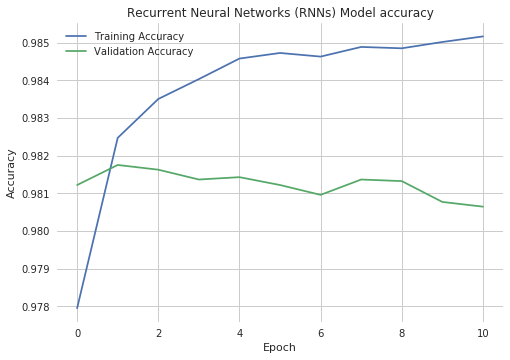

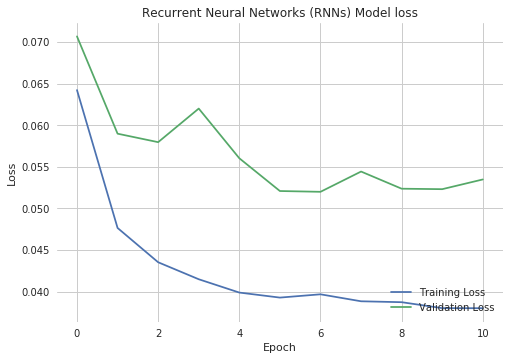

In [0]:
# Plot training & validation accuracy values
plt.plot(RNN_model_fit.history['acc'])
plt.plot(RNN_model_fit.history['val_acc'])
plt.title('Recurrent Neural Networks (RNNs) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(RNN_model_fit.history['loss'])
plt.plot(RNN_model_fit.history['val_loss'])
plt.title('Recurrent Neural Networks (RNNs) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### USING PRE-TRAINED EMBEDDING

## A) "Glove" as a pre-trained Embedding

#### Prepare the pre-trained embedding layer

Load glove embedding corpus

In [0]:
glove_file = open('glove.6B.100d.txt', encoding="utf8")
embeddings_index = dict()
for line in glove_file:
    val = line.split(' ')
    word = val[0]
    coefs = np.asarray(val[1:], dtype='float32')
    embeddings_index[word] = coefs
glove_file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


#### Prepare the embedding matrix vectors in order to feed/pass the neural network

In [0]:
# create a weight matrix
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### 4) Convolutional Neural Network (CNN) with Glove

In [0]:
CNN_Glove_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

CNN_Glove_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

### Visualize the Orchestrated CNN-Glove Model Architecture

In [0]:
CNN_Glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          21033800  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 100)          40100     
_________________________________________________________________
batch_normalization_3 (Batch (None, 200, 100)          400       
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
__________

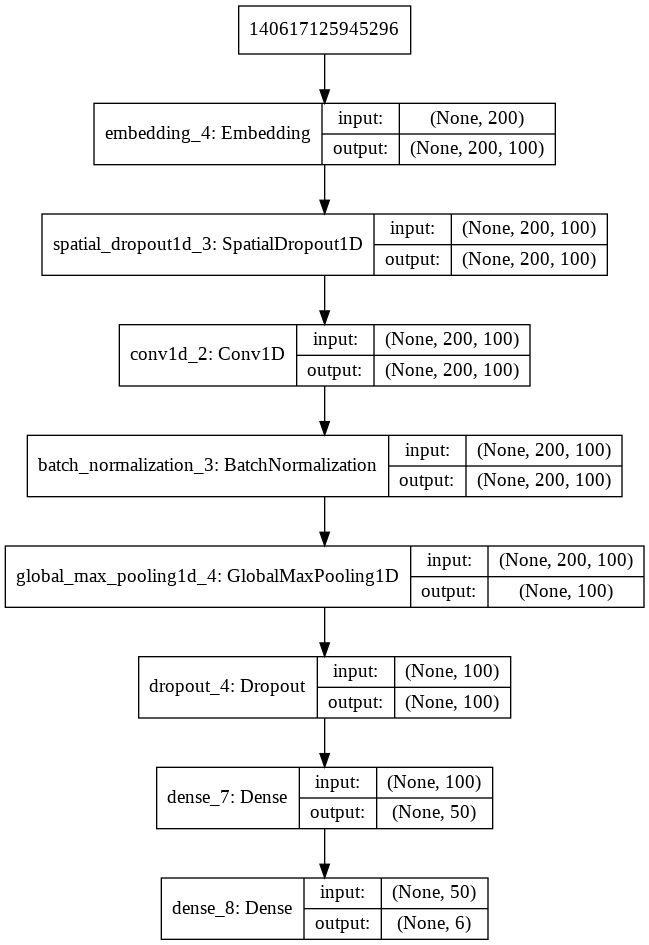

In [0]:
#plot the CNN_GLove model architecture

plot_model(CNN_Glove_model, to_file='CNN_Glove_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_Glove_model_plot.png')

In [0]:
CNN_Glove_model_fit = CNN_Glove_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 9s 60us/step - loss: 0.1131 - acc: 0.9681 - mean_pred: 0.0387 - fmeasure: 0.3961 - precision: 0.6642 - auroc: 0.8256 - recall: 0.2967 - val_loss: 0.0783 - val_acc: 0.9729 - val_mean_pred: 0.0411 - val_fmeasure: 0.4496 - val_precision: 0.8967 - val_auroc: 0.8912 - val_recall: 0.3043
Epoch 2/25
143613/143613 [==============================] - 7s 52us/step - loss: 0.0824 - acc: 0.9727 - mean_pred: 0.0373 - fmeasure: 0.5096 - precision: 0.7458 - auroc: 0.9066 - recall: 0.4024 - val_loss: 0.0683 - val_acc: 0.9762 - val_mean_pred: 0.0301 - val_fmeasure: 0.5539 - val_precision: 0.8863 - val_auroc: 0.9172 - val_recall: 0.4078
Epoch 3/25
143613/143613 [==============================] - 7s 52us/step - loss: 0.0772 - acc: 0.9739 - mean_pred: 0.0367 - fmeasure: 0.5373 - precision: 0.7608 - auroc: 0.9237 - recall: 0.4277 - val_loss: 0.0627 - val_acc: 0.9783 - val_mean_pred: 0.0368 - val_fm

### Evaluate the CNN+Glove Model accuracy of our trained model

In [0]:
CNN_Glove_train_score = CNN_Glove_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Glove_train_score[0])
print('Train Accuracy:', CNN_Glove_train_score[1])

159571/159571 [==============================] - 4s 22us/step
Train Loss: 0.05648058112909036
Train Accuracy: 0.9793654976626162


### Evaluate the CNN+Glove accuracy base our test samples

In [0]:
CNN_Glove_test_score = CNN_Glove_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Glove_test_score[0])
print('Test Accuracy:', CNN_Glove_test_score[1])

63930/63930 [==============================] - 1s 22us/step
Test Loss: 0.06995492693897463
Test Accuracy: 0.9730460324142715


In [0]:
#Predicting......
print('Predicting....')
y_pred = CNN_Glove_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 1s 23us/step


### Plot Training & Validation Accuracy with the Loss values of the CNN-Glove Model

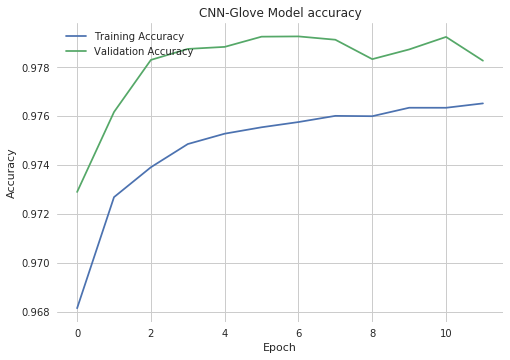

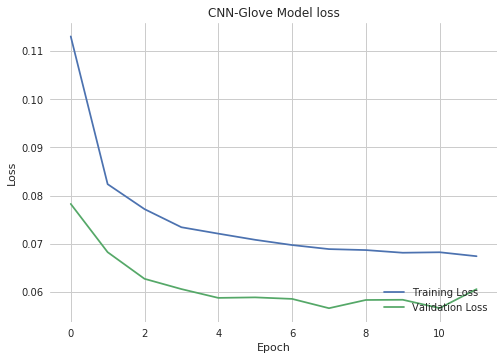

In [0]:
# Plot training & validation accuracy values
plt.plot(CNN_Glove_model_fit.history['acc'])
plt.plot(CNN_Glove_model_fit.history['val_acc'])
plt.title('CNN-Glove Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_Glove_model_fit.history['loss'])
plt.plot(CNN_Glove_model_fit.history['val_loss'])
plt.title('CNN-Glove Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 5) Recurrent Neural Network (RNN) with Glove

In [0]:
RNN_Glove_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

RNN_Glove_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

### Visualize the Orchestrated RNN-Glove MODEL Architecture

In [0]:
RNN_Glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          21033800  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 100)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 50)           25200     
_________________________________________________________________
batch_normalization_4 (Batch (None, 200, 50)           200       
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
__________

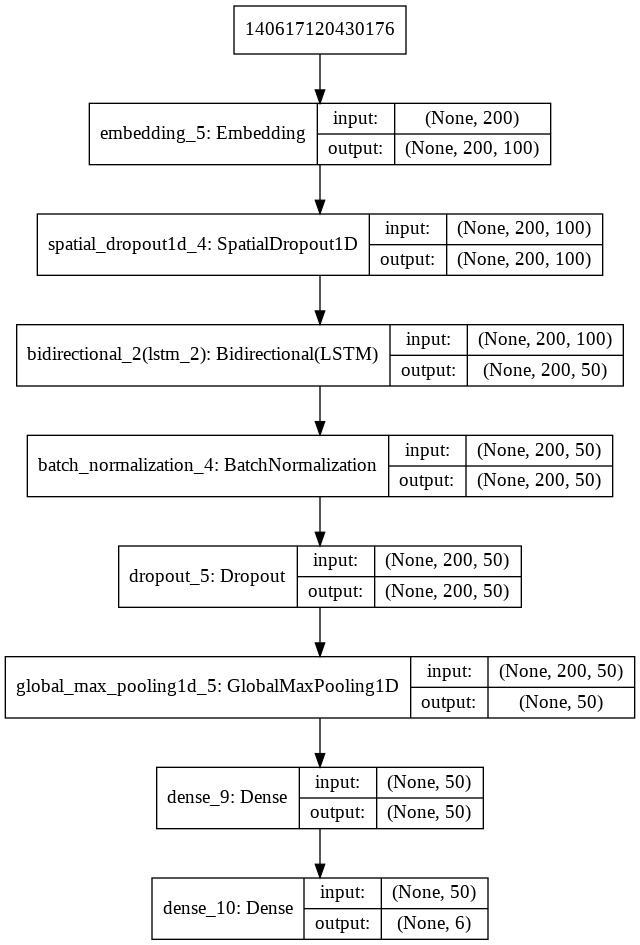

In [0]:
#plot the RNN_GLove model architecture

plot_model(RNN_Glove_model, to_file='RNN_Glove_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='RNN_Glove_model_plot.png')

In [0]:
RNN_Glove_model_fit = RNN_Glove_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 331s 2ms/step - loss: 0.0846 - acc: 0.9724 - mean_pred: 0.0373 - fmeasure: 0.4989 - precision: 0.7250 - auroc: 0.8818 - recall: 0.4078 - val_loss: 0.0782 - val_acc: 0.9787 - val_mean_pred: 0.0601 - val_fmeasure: 0.6445 - val_precision: 0.8240 - val_auroc: 0.9385 - val_recall: 0.5348
Epoch 2/25
143613/143613 [==============================] - 328s 2ms/step - loss: 0.0655 - acc: 0.9772 - mean_pred: 0.0368 - fmeasure: 0.6215 - precision: 0.7822 - auroc: 0.9461 - recall: 0.5236 - val_loss: 0.0872 - val_acc: 0.9799 - val_mean_pred: 0.0737 - val_fmeasure: 0.6834 - val_precision: 0.8095 - val_auroc: 0.9508 - val_recall: 0.5966
Epoch 3/25
143613/143613 [==============================] - 325s 2ms/step - loss: 0.0629 - acc: 0.9780 - mean_pred: 0.0367 - fmeasure: 0.6370 - precision: 0.7893 - auroc: 0.9531 - recall: 0.5425 - val_loss: 0.0692 - val_acc: 0.9797 - val_mean_pred: 0.0547 - val

### Evaluate the RNN-Glove Model accuracy of our trained model

In [0]:
RNN_Glove_train_score = RNN_Glove_model.evaluate(X_train, y_train, batch_size = batch_size2, verbose = 1)
print('Train loss:', RNN_Glove_train_score[0])
print('Train accuracy:', RNN_Glove_train_score[1])

159571/159571 [==============================] - 150s 941us/step
Train loss: 0.06282929686179727
Train accuracy: 0.9807891038570823


### Evaluate the RNN-Glove accuracy base our test samples

In [0]:
RNN_Glove_test_score = RNN_Glove_model.evaluate(X_test, y_test, batch_size = batch_size2, verbose = 1)
print('Test loss:', RNN_Glove_test_score[0])
print('Test accuracy:', RNN_Glove_test_score[1])

63930/63930 [==============================] - 59s 922us/step
Test loss: 0.08763624270109062
Test accuracy: 0.9698055051552676


italicized text### Plot Training & Validation Accuracy with the Loss values of the RNN-Glove Model

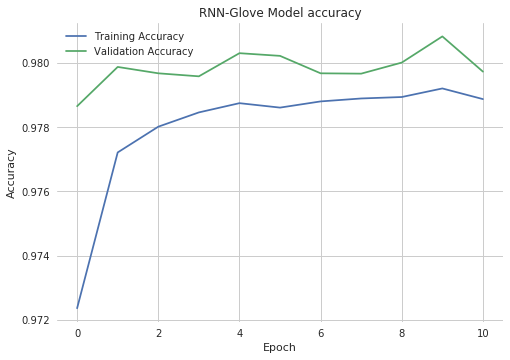

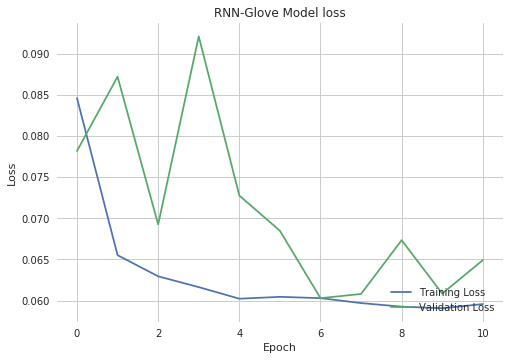

In [0]:
# Plot training & validation accuracy values
plt.plot(RNN_Glove_model_fit.history['acc'])
plt.plot(RNN_Glove_model_fit.history['val_acc'])
plt.title('RNN-Glove Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(RNN_Glove_model_fit.history['loss'])
plt.plot(RNN_Glove_model_fit.history['val_loss'])
plt.title('RNN-Glove Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

## B) "Word2Vec" as a pre-Trained Embedding

Firstly, we separately learnt word embeddings and then pass to the embedding layer. This approach allows to use  pre-trained (Word2Vec) word embedding and also saves the time in training the classification model.

In this part of experiment, we used Geness implementaion of Word2Vec.

### Create the word tokens in order to prepare the Text corpus for leanring the embedding

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
toxicComments_lines = list()
lines = train['comment_text'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    
    #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    table =  str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    #remove remaining tpkens gthat are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    #filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    toxicComments_lines.append(words)


len(toxicComments_lines)

159571

### Train the Word2Vec

In [0]:
#train word2vec mode
embedding_dims = 128 #embedding vector output dimension 
max_len = 200 #Max. number of words per toxic comment to be use
word2VecModel = gensim.models.Word2Vec(sentences=toxicComments_lines, size= embedding_dims, window=5, workers=4, min_count=1)
#vocab size
wors = list(word2VecModel.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 19


#### Test Word2Vec Model of the toxic comment corpus. We tried some word embeddings from the model learnt from the wikipedia toxic comment tran dataset

In [0]:
word2VecModel.wv.most_similar('shit')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('worthless', 0.8063541650772095),
 ('ass', 0.787983775138855),
 ('crap', 0.7839124202728271),
 ('fucking', 0.7806130647659302),
 ('garbage', 0.7781463265419006),
 ('asshole', 0.771328330039978),
 ('goddamn', 0.7470780611038208),
 ('scum', 0.7432743906974792),
 ('pile', 0.7429719567298889),
 ('retards', 0.740914523601532)]

In [0]:
#Let's see the reulst of semantically reasonable word vetors (king - man + woman)
word2VecModel.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('born', 1.057712197303772),
 ('prince', 1.0532325506210327),
 ('emperor', 1.0447297096252441),
 ('kings', 1.0300096273422241),
 ('iiird', 1.0192967653274536),
 ('crown', 1.01779305934906),
 ('reigned', 1.0168734788894653),
 ('aragon', 1.01659095287323),
 ('queen', 1.0117380619049072),
 ('grandfather', 1.0099326372146606)]

In [0]:
#Let us find the odd word woman, king, queen, movie = ?
#add word out
print(word2VecModel.wv.doesnt_match("woman king queen movie".split()))

movie


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



#### Save the Word2Vec Corpus locally

In [0]:
#save model
filename = 'toxic_embedding_word2vec.txt'
word2VecModel.wv.save_word2vec_format(filename, binary=False)

### Use the Pre-Trained Embedding (Word2Vec) in our models (CNN, and RNN)

In [0]:
word2Vec_embeddings_index = {}
word2vec_file = open(os.path.join('', 'toxic_embedding_word2vec.txt'), encoding = "utf-8")

for line in word2vec_file:
    values = line.split()
    word = values[0]
    coefficient = np.asarray(values[1:])
    word2Vec_embeddings_index[word] = coefficient
word2vec_file.close()

#### Convert the word embedding into tokenized vector

In [0]:
#vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(toxicComments_lines)
sequences = tokenizer_obj.texts_to_sequences(toxicComments_lines)

#pad sequences
word_index = tokenizer_obj.word_index
print('Found %s uniquue tokens.' % len(word_index))

toxicComments_pad = pad_sequences(sequences, maxlen=max_len)
comments_tag = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
print('Shape of toxic comments tensor', toxicComments_pad.shape)
print('Shape of comment tensor', comments_tag.shape)

Found 199068 uniquue tokens.
Shape of toxic comments tensor (159571, 200)
Shape of comment tensor (159571, 6)


#### We mapped the embeddings from the loaded word2vec model so that each word to the tokenizer_obj.word_index vocabulary and create a matrix with of word vectors.

In [0]:
num_words = len(word_index)+1
word2Vec_embedding_matrix = np.zeros((num_words, embedding_dims))

for word, i  in word_index.items():
    if i > num_words:
        continue
    word2Vec_embedding_vector = word2Vec_embeddings_index.get(word)
    if word2Vec_embedding_vector is not None:
        #words not found in embedding index will be all-zeros.
        word2Vec_embedding_matrix[i] = word2Vec_embedding_vector

print(num_words)
print(word2Vec_embedding_matrix.shape[0])
print(word2Vec_embedding_matrix.shape[1])

199069
199069
128


### 6) Convolutional Neural Network (CNN) with Word2Vec

In [0]:
CNN_Word2Vec_model = Sequential([
    Embedding(input_dim =word2Vec_embedding_matrix.shape[0], input_length=max_len, output_dim=word2Vec_embedding_matrix.shape[1],weights=[word2Vec_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

CNN_Word2Vec_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])


#### Visualize the Orchestrated CNN-Glove Model Architecture

In [0]:
CNN_Word2Vec_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 128)          25480832  
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 200, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 100)          51300     
_________________________________________________________________
batch_normalization_5 (Batch (None, 200, 100)          400       
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 100)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
__________

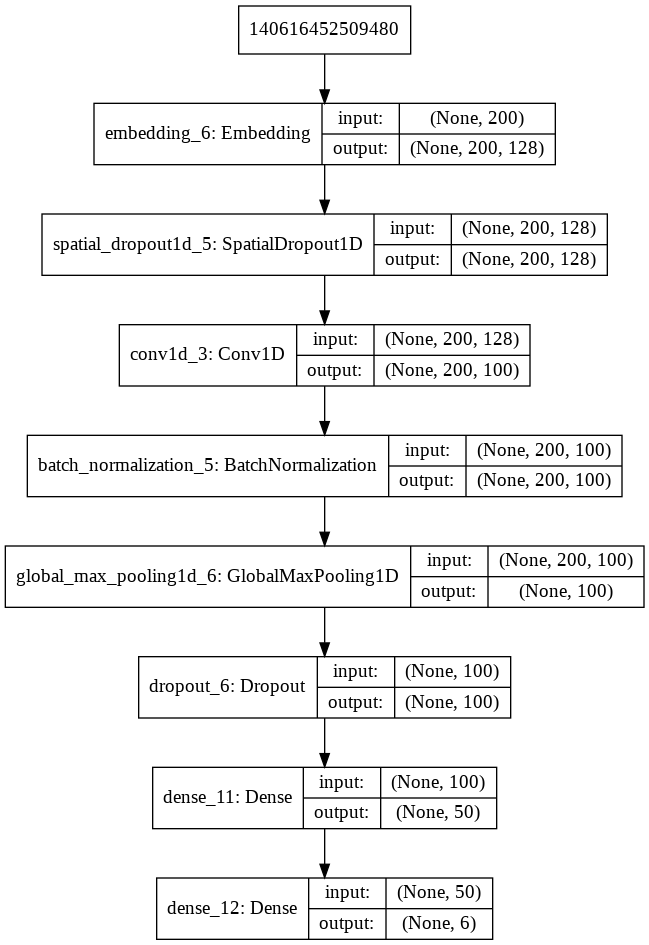

In [0]:
#plot the CNN_Word2Vec_model architecture

plot_model(CNN_Word2Vec_model, to_file='CNN_Word2Vec_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_Word2Vec_model_plot.png')

In [0]:
CNN_Word2Vec_model_fit = CNN_Word2Vec_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 10s 69us/step - loss: 0.1672 - acc: 0.9633 - mean_pred: 0.0364 - fmeasure: 0.0956 - precision: 0.4614 - auroc: 0.7278 - recall: 0.0566 - val_loss: 0.1130 - val_acc: 0.9655 - val_mean_pred: 0.0461 - val_fmeasure: 0.1365 - val_precision: 0.8794 - val_auroc: 0.7982 - val_recall: 0.0760
Epoch 2/25
143613/143613 [==============================] - 8s 55us/step - loss: 0.1096 - acc: 0.9676 - mean_pred: 0.0372 - fmeasure: 0.2689 - precision: 0.7578 - auroc: 0.8230 - recall: 0.1688 - val_loss: 0.0958 - val_acc: 0.9693 - val_mean_pred: 0.0366 - val_fmeasure: 0.3173 - val_precision: 0.8635 - val_auroc: 0.8407 - val_recall: 0.2010
Epoch 3/25
143613/143613 [==============================] - 8s 55us/step - loss: 0.1031 - acc: 0.9688 - mean_pred: 0.0370 - fmeasure: 0.3278 - precision: 0.7601 - auroc: 0.8521 - recall: 0.2154 - val_loss: 0.0906 - val_acc: 0.9704 - val_mean_pred: 0.0359 - val_f

#### Evaluate the CNN+Word2Vec Model accuracy of our trained model

In [0]:
CNN_Word2Vec_train_score = CNN_Word2Vec_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Word2Vec_train_score[0])
print('Train Accuracy:', CNN_Word2Vec_train_score[1])

159571/159571 [==============================] - 4s 23us/step
Train Loss: 0.07261239619843593
Train Accuracy: 0.9755343927119746


#### Evaluate the CNN+Word2Vec accuracy base our test samples

In [0]:
CNN_Word2Vec_test_score = CNN_Word2Vec_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Word2Vec_test_score[0])
print('Test Accuracy:', CNN_Word2Vec_test_score[1])

63930/63930 [==============================] - 1s 23us/step
Test Loss: 0.09284712989614563
Test Accuracy: 0.9696021636084698


In [0]:
#Predicting......
print('Predicting....')
y_pred = CNN_Word2Vec_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 2s 27us/step


#### Plot Training & Validation Accuracy with the Loss values of the CNN-Word2Vec Model

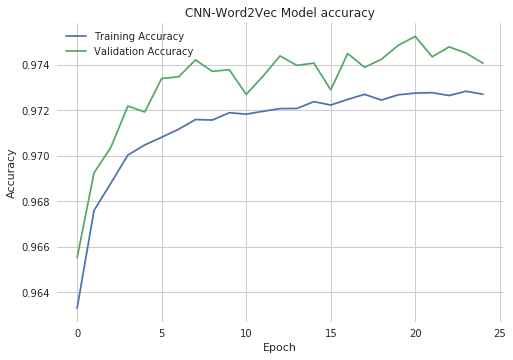

In [0]:
# Plot training & validation accuracy values
plt.plot(CNN_Word2Vec_model_fit.history['acc'])
plt.plot(CNN_Word2Vec_model_fit.history['val_acc'])
plt.title('CNN-Word2Vec Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()


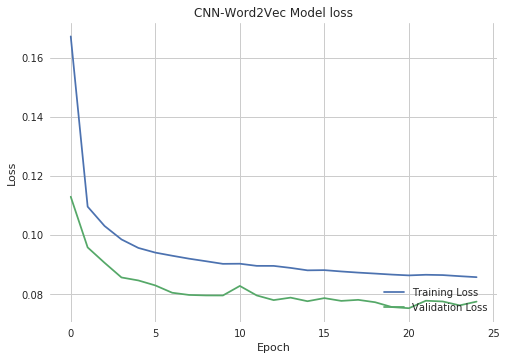

In [0]:
# Plot training & validation loss values
plt.plot(CNN_Word2Vec_model_fit.history['loss'])
plt.plot(CNN_Word2Vec_model_fit.history['val_loss'])
plt.title('CNN-Word2Vec Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 7) Recurrent Neural Network (RNN) with Word2Vec

In [0]:
RNN_Word2Vec_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

RNN_Word2Vec_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, ])

####Visualize the Orchestrated RNN-Word2Vec Model Architecture

In [0]:
RNN_Word2Vec_model.summary()

In [0]:
#plot the RNN_Word2Vec_model architecture

plot_model(RNN_Word2Vec_model, to_file='RNN_Word2Vec_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='RNN_Word2Vec_model_plot.png')

In [0]:
RNN_Word2Vec_model_fit = RNN_Word2Vec_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 335s 2ms/step - loss: 0.0816 - acc: 0.9730 - mean_pred: 0.0377 - fmeasure: 0.5416 - precision: 0.7323 - auroc: 0.9027 - recall: 0.4489 - val_loss: 0.0887 - val_acc: 0.9789 - val_mean_pred: 0.0723 - val_fmeasure: 0.6529 - val_precision: 0.8252 - val_auroc: 0.9434 - val_recall: 0.5452
Epoch 2/25
143613/143613 [==============================] - 329s 2ms/step - loss: 0.0652 - acc: 0.9772 - mean_pred: 0.0367 - fmeasure: 0.6222 - precision: 0.7789 - auroc: 0.9492 - recall: 0.5278 - val_loss: 0.0749 - val_acc: 0.9797 - val_mean_pred: 0.0605 - val_fmeasure: 0.6782 - val_precision: 0.8068 - val_auroc: 0.9534 - val_recall: 0.5906
Epoch 3/25
143613/143613 [==============================] - 334s 2ms/step - loss: 0.0633 - acc: 0.9777 - mean_pred: 0.0368 - fmeasure: 0.6333 - precision: 0.7821 - auroc: 0.9557 - recall: 0.5407 - val_loss: 0.0662 - val_acc: 0.9795 - val_mean_pred: 0.0498 - val

#### Evaluate the RNN+Word2Vec Model accuracy of our trained model

In [0]:
RNN_Word2Vec_train_score = RNN_Word2Vec_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', RNN_Word2Vec_train_score[0])
print('Train Accuracy:', RNN_Word2Vec_train_score[1])

159571/159571 [==============================] - 150s 940us/step
Train Loss: 0.06868015842966801
Train Accuracy: 0.9810951336479722


#### Evaluate the RNN+Word2Vec accuracy base our test samples

In [0]:
RNN_Word2Vec_test_score = RNN_Word2Vec_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', RNN_Word2Vec_test_score[0])
print('Test Accuracy:', RNN_Word2Vec_test_score[1])

63930/63930 [==============================] - 60s 945us/step
Test Loss: 0.09752105291150237
Test Accuracy: 0.9691276808421264


In [0]:
#Predicting......
print('Predicting....')
y_pred = RNN_Word2Vec_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 62s 965us/step


#### Plot Training & Validation Accuracy with the Loss values of the RNN-Word2Vec Model

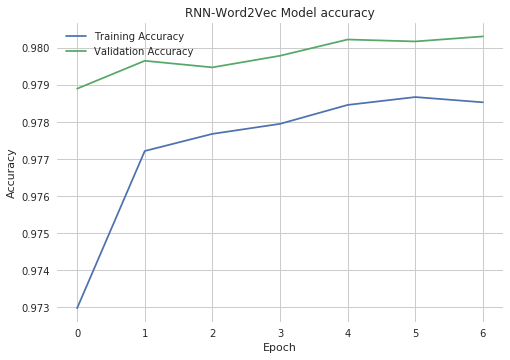

In [0]:
# Plot training & validation accuracy values
plt.plot(RNN_Word2Vec_model_fit.history['acc'])
plt.plot(RNN_Word2Vec_model_fit.history['val_acc'])
plt.title('RNN-Word2Vec Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

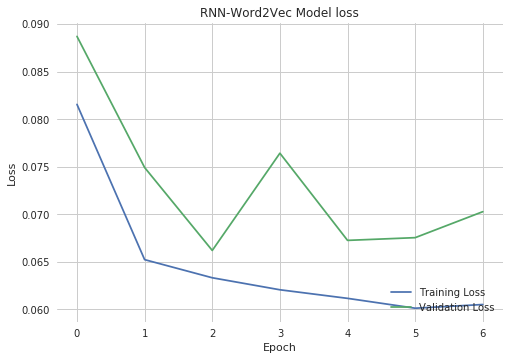

In [0]:
# Plot training & validation loss values
plt.plot(RNN_Word2Vec_model_fit.history['loss'])
plt.plot(RNN_Word2Vec_model_fit.history['val_loss'])
plt.title('RNN-Word2Vec Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

## C) "FasText" as a pre-trained Embedding

#### Load the FastText Word Embeddng Corpus

In [0]:
#load embeddings
print('loading word embeddings...')
fastText_embeddings_index = {}
f = codecs.open('wiki.simple (1).vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    fastText_embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(fastText_embeddings_index))

840it [00:00, 8392.52it/s]

loading word embeddings...


111052it [00:12, 9210.79it/s]

found 111052 word vectors


In [0]:
#embedding matrix
print('preparing embedding matrix...')
max_nb_words = 100000
fastText_embed_dim = 300 

words_not_found = []
nb_words = min(max_nb_words, len(word_index))
fastText_embedding_matrix = np.zeros((nb_words, fastText_embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    fastText_embedding_vector = fastText_embeddings_index.get(word)
    if (fastText_embedding_vector is not None) and len(fastText_embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        fastText_embedding_matrix[i] = fastText_embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(fastText_embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 51837


In [0]:
print(nb_words)

100000


### 8) Convolutional Neural Network (CNN) with FastText

In [0]:
CNN_FastText_model = Sequential([
    Embedding(input_dim=fastText_embedding_matrix.shape[0], input_length=max_len, output_dim=fastText_embedding_matrix.shape[1],weights=[fastText_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [0]:
CNN_FastText_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

#### Visualize the Orchestrated CNN-FastText Model Architecture

In [0]:
CNN_FastText_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 300)          30000000  
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 200, 300)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 200, 100)          120100    
_________________________________________________________________
batch_normalization_7 (Batch (None, 200, 100)          400       
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 100)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                5050      
__________

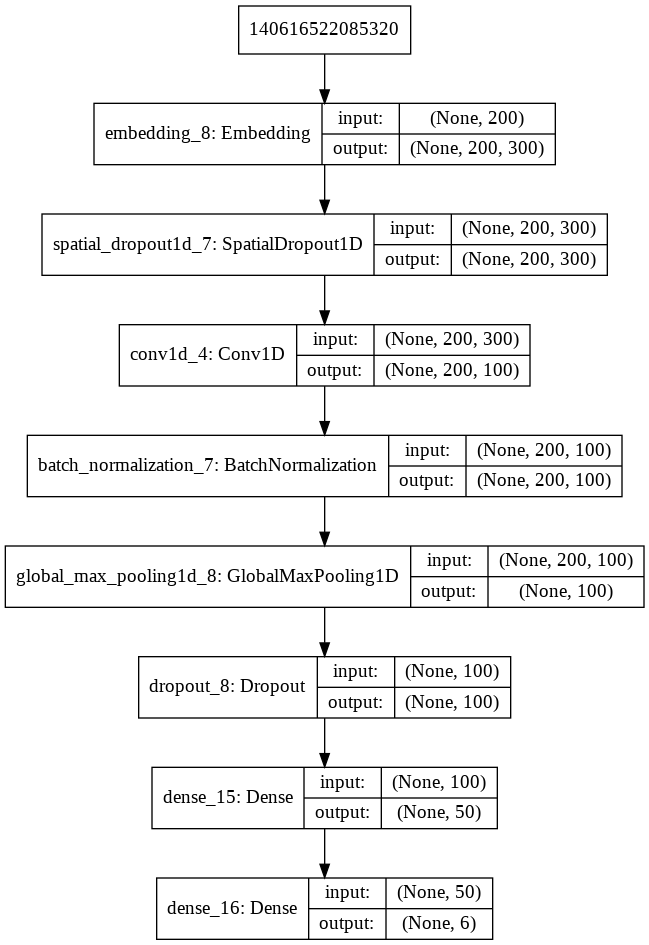

In [0]:
#plot the CNN_FastText_model architecture

plot_model(CNN_FastText_model, to_file='CNN_FastText_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_FastText_model_plot.png')

In [0]:
CNN_FastText_model_fit = CNN_FastText_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 14s 100us/step - loss: 0.1364 - acc: 0.9638 - mean_pred: 0.0387 - fmeasure: 0.0882 - precision: 0.3924 - auroc: 0.7685 - recall: 0.0525 - val_loss: 0.1146 - val_acc: 0.9630 - val_mean_pred: 0.0322 - val_fmeasure: 0.0142 - val_precision: 0.2781 - val_auroc: 0.8202 - val_recall: 0.0073
Epoch 2/25
143613/143613 [==============================] - 12s 81us/step - loss: 0.1060 - acc: 0.9690 - mean_pred: 0.0372 - fmeasure: 0.3220 - precision: 0.7792 - auroc: 0.8404 - recall: 0.2111 - val_loss: 0.0884 - val_acc: 0.9729 - val_mean_pred: 0.0385 - val_fmeasure: 0.4305 - val_precision: 0.9034 - val_auroc: 0.8570 - val_recall: 0.2908
Epoch 3/25
143613/143613 [==============================] - 12s 81us/step - loss: 0.0934 - acc: 0.9721 - mean_pred: 0.0370 - fmeasure: 0.4500 - precision: 0.7879 - auroc: 0.8688 - recall: 0.3232 - val_loss: 0.0814 - val_acc: 0.9737 - val_mean_pred: 0.0268 - va

#### Evaluate the CNN+fastText Model accuracy of our trained model

In [0]:
CNN_FastText_train_score = CNN_FastText_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_FastText_train_score[0])
print('Train Accuracy:', CNN_FastText_train_score[1])

159571/159571 [==============================] - 6s 35us/step
Train Loss: 0.05990092805353736
Train Accuracy: 0.9797582165958889


#### Evaluate the CNN+FastText accuracy base our test samples

In [0]:
CNN_FastText_test_score = CNN_FastText_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_FastText_train_score[0])
print('Test Accuracy:', CNN_FastText_train_score[1])

63930/63930 [==============================] - 2s 35us/step
Test Loss: 0.05990092805353736
Test Accuracy: 0.9797582165958889


In [0]:
#Predicting......
print('Predicting....')
y_pred = CNN_FastText_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 3s 42us/step


#### Plot Training & Validation Accuracy with the Loss values of the CNN-FastText Model

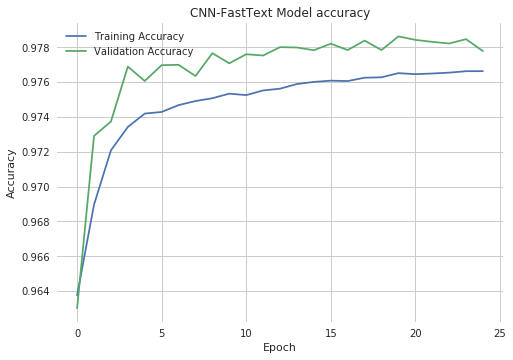

In [0]:
# Plot training & validation accuracy values
plt.plot(CNN_FastText_model_fit.history['acc'])
plt.plot(CNN_FastText_model_fit.history['val_acc'])
plt.title('CNN-FastText Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

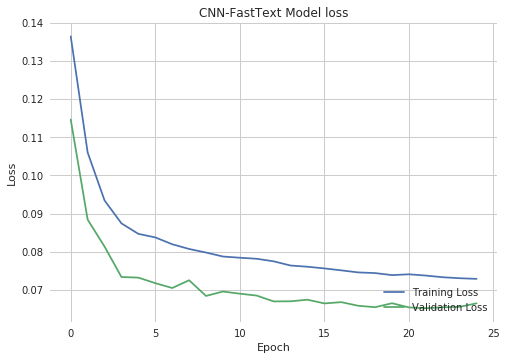

In [0]:
# Plot training & validation loss values
plt.plot(CNN_FastText_model_fit.history['loss'])
plt.plot(CNN_FastText_model_fit.history['val_loss'])
plt.title('CNN-FastText Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 9) Recurrent Neural Network (RNN) with FastText

In [0]:
RNN_FastText_model = Sequential([
    Embedding(input_dim =fastText_embedding_matrix.shape[0], input_length=max_len, output_dim=fastText_embedding_matrix.shape[1],weights=[fastText_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [0]:
RNN_FastText_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred, fmeasure, precision, auroc, recall])

#### Visualize the Orchestrated RNN-fastText Model Architecture

In [0]:
RNN_FastText_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 300)          30000000  
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 200, 300)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200, 50)           65200     
_________________________________________________________________
batch_normalization_8 (Batch (None, 200, 50)           200       
_________________________________________________________________
dropout_9 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
__________

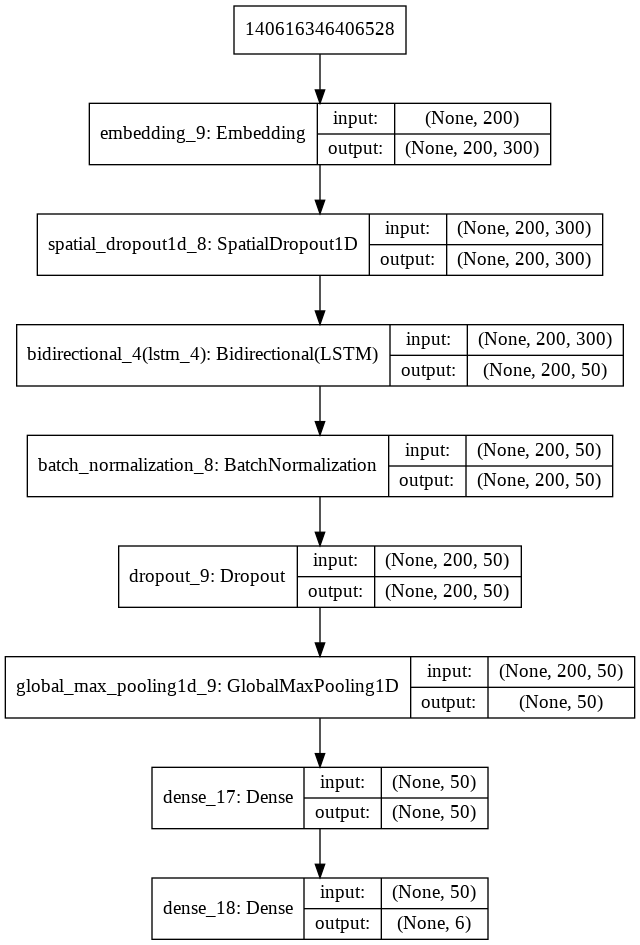

In [0]:
#plot the RNN_FastText_model architecture

plot_model(RNN_FastText_model, to_file='RNN_FastText_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='RNN_FastText_model_plot.png')

In [0]:
RNN_FastText_model_fit = RNN_FastText_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 341s 2ms/step - loss: 0.1086 - acc: 0.9688 - mean_pred: 0.0370 - fmeasure: 0.3385 - precision: 0.6312 - auroc: 0.8286 - recall: 0.2454 - val_loss: 0.1270 - val_acc: 0.9753 - val_mean_pred: 0.1010 - val_fmeasure: 0.5471 - val_precision: 0.8270 - val_auroc: 0.8864 - val_recall: 0.4164
Epoch 2/25
143613/143613 [==============================] - 337s 2ms/step - loss: 0.0800 - acc: 0.9749 - mean_pred: 0.0367 - fmeasure: 0.5468 - precision: 0.7985 - auroc: 0.8995 - recall: 0.4252 - val_loss: 0.0893 - val_acc: 0.9769 - val_mean_pred: 0.0663 - val_fmeasure: 0.5978 - val_precision: 0.8224 - val_auroc: 0.9112 - val_recall: 0.4788
Epoch 3/25
143613/143613 [==============================] - 334s 2ms/step - loss: 0.0747 - acc: 0.9764 - mean_pred: 0.0366 - fmeasure: 0.5855 - precision: 0.8034 - auroc: 0.9179 - recall: 0.4687 - val_loss: 0.0937 - val_acc: 0.9776 - val_mean_pred: 0.0744 - val

#### Evaluate the RNN+fastText Model accuracy of our trained model

In [0]:
RNN_FastText_train_score = RNN_FastText_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', RNN_FastText_train_score[0])
print('Train Accuracy:', RNN_FastText_train_score[1])

159571/159571 [==============================] - 153s 957us/step
Train Loss: 0.06023678262240983
Train Accuracy: 0.9803650521283138


#### Evaluate the RNN+FastText accuracy base our test samples

In [0]:
RNN_FastText_test_score = RNN_FastText_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', RNN_FastText_test_score[0])
print('Test Accuracy:', RNN_FastText_test_score[1])

63930/63930 [==============================] - 60s 937us/step
Test Loss: 0.084540696949438
Test Accuracy: 0.9705198339056227


In [0]:
#Predicting......
print('Predicting....')
y_pred = RNN_FastText_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 61s 958us/step


#### Plot Training & Validation Accuracy with the Loss values of the RNN-fastText Model

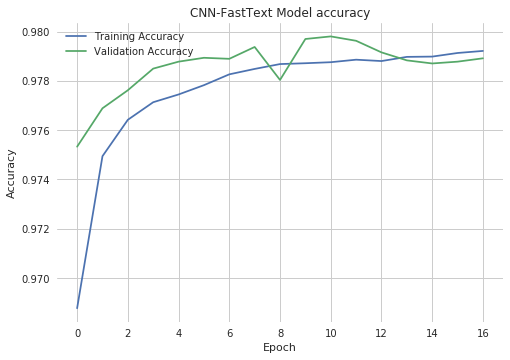

In [0]:
# Plot training & validation accuracy values
plt.plot(RNN_FastText_model_fit.history['acc'])
plt.plot(RNN_FastText_model_fit.history['val_acc'])
plt.title('CNN-FastText Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

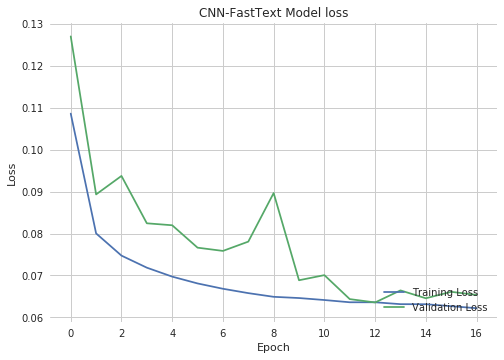

In [0]:
# Plot training & validation loss values
plt.plot(RNN_FastText_model_fit.history['loss'])
plt.plot(RNN_FastText_model_fit.history['val_loss'])
plt.title('CNN-FastText Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### EVALUATION

#### Computing the highest of the evaluation matrics (per model) 

In [0]:
trace = go.Table(
    header=dict(values=['Model', 'Loss', 'Accuracy', 'mean_pred', 'F-Measure', 'Precision', 'AUC', 'Recall'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['left'] * 5),
    cells=dict(values=[['Neural Network', 'CNN', 'RNNs', 'CNN-Glove', 'RNNs-Glove', 'CNNs-Word2Vec', 'RNNs-Word2Vec', 'CNNs-FastText', 'RNNs-FastText'],
                       [
                        #Loss Evaluation
                        round(np.max(nn_model_fit.history['loss']), 3), round(np.max(CNN_model_fit.history['loss']), 3), round(np.max(RNN_model_fit.history['loss']), 3), 
                        round(np.max(CNN_Glove_model_fit.history['loss']), 3), round(np.max(RNN_Glove_model_fit.history['loss']), 3), round(np.max(CNN_Word2Vec_model_fit.history['loss']), 3),
                        round(np.max(RNN_Word2Vec_model_fit.history['loss']), 3), round(np.max(CNN_FastText_model_fit.history['loss']), 3), round(np.max(RNN_FastText_model_fit.history['loss']), 3)],
                        
                        #Accuracy Evaluation
                        [round(np.max(nn_model_fit.history['acc']), 3), round(np.max(CNN_model_fit.history['acc']), 3), round(np.max(RNN_model_fit.history['acc']), 3), 
                        round(np.max(CNN_Glove_model_fit.history['acc']), 3), round(np.max(RNN_Glove_model_fit.history['acc']), 3), round(np.max(CNN_Word2Vec_model_fit.history['acc']), 3), 
                        round(np.max(RNN_Word2Vec_model_fit.history['acc']), 3), round(np.max(CNN_FastText_model_fit.history['acc']), 3), round(np.max(RNN_FastText_model_fit.history['acc']), 3)],
               
                        #mean_pred Evaluation
                        [round(np.max(nn_model_fit.history['mean_pred']), 3), round(np.max(CNN_model_fit.history['mean_pred']), 3), round(np.max(RNN_model_fit.history['mean_pred']), 3), 
                        round(np.max(CNN_Glove_model_fit.history['mean_pred']), 3), round(np.max(RNN_Glove_model_fit.history['mean_pred']), 3), round(np.max(CNN_Word2Vec_model_fit.history['mean_pred']), 3), 
                        round(np.max(RNN_Word2Vec_model_fit.history['mean_pred']), 3), round(np.max(CNN_FastText_model_fit.history['mean_pred']), 3), round(np.max(RNN_FastText_model_fit.history['mean_pred']),3)],
               
                        #F1-Measure Evaluation
                        [round(np.max(nn_model_fit.history['fmeasure']), 3), round(np.max(CNN_model_fit.history['fmeasure']), 3), round(np.max(RNN_model_fit.history['fmeasure']), 3), 
                        round(np.max(CNN_Glove_model_fit.history['fmeasure']), 3), round(np.max(RNN_Glove_model_fit.history['fmeasure']), 3), round(np.max(CNN_Word2Vec_model_fit.history['fmeasure']), 3), 
                        round(np.max(RNN_Word2Vec_model_fit.history['fmeasure']), 3), round(np.max(CNN_FastText_model_fit.history['fmeasure']), 3), round(np.max(RNN_FastText_model_fit.history['fmeasure']), 3)],
               
                        #Precision Evaluation
                        [round(np.max(nn_model_fit.history['precision']), 3), round(np.max(CNN_model_fit.history['precision']), 3), round(np.mean(RNN_model_fit.history['precision']), 3), 
                        round(np.max(CNN_Glove_model_fit.history['precision']), 3), round(np.max(RNN_Glove_model_fit.history['precision']), 3), round(np.mean(CNN_Word2Vec_model_fit.history['precision']), 3), 
                        round(np.max(RNN_Word2Vec_model_fit.history['precision']), 3), round(np.max(CNN_FastText_model_fit.history['precision']), 3), round(np.mean(RNN_FastText_model_fit.history['precision']), 3)],
                        
                        #ROC AUC Evaluation
                        [round(np.max(nn_model_fit.history['auroc']), 3), round(np.max(CNN_model_fit.history['auroc']), 3), round(np.max(RNN_model_fit.history['auroc']), 3), 
                        round(np.max(CNN_Glove_model_fit.history['auroc']), 3), round(np.max(RNN_Glove_model_fit.history['auroc']), 3), round(np.max(CNN_Word2Vec_model_fit.history['auroc']), 3), 
                        round(np.max(RNN_Word2Vec_model_fit.history['auroc']), 3), round(np.max(CNN_FastText_model_fit.history['auroc']), 3), round(np.max(RNN_FastText_model_fit.history['auroc']), 3)],
                       
                       
                        #Recall Evaluation
                        [round(np.max(nn_model_fit.history['recall']), 3), round(np.max(CNN_model_fit.history['recall']), 3), round(np.max(RNN_model_fit.history['recall']), 3), 
                        round(np.max(CNN_Glove_model_fit.history['recall']), 3), round(np.max(RNN_Glove_model_fit.history['recall']), 3), round(np.max(CNN_Word2Vec_model_fit.history['recall']), 3), 
                        round(np.max(RNN_Word2Vec_model_fit.history['recall']), 3), round(np.max(CNN_FastText_model_fit.history['recall']), 3), round(np.max(RNN_FastText_model_fit.history['recall']), 3)]
                       ],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['left'] * 5))

layout = dict(width=800, height=400)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(data, filename = 'multi-label_with the max of the evaluation matrics (per model) _table')

#### Computing the mean average of the evaluation matrics (per model) 

In [0]:
from google.colab import files
from IPython.display import Image

uploaded = files.upload()

Saving multi-label_with the max of the evaluation matrics (per model) _table.png to multi-label_with the max of the evaluation matrics (per model) _table.png


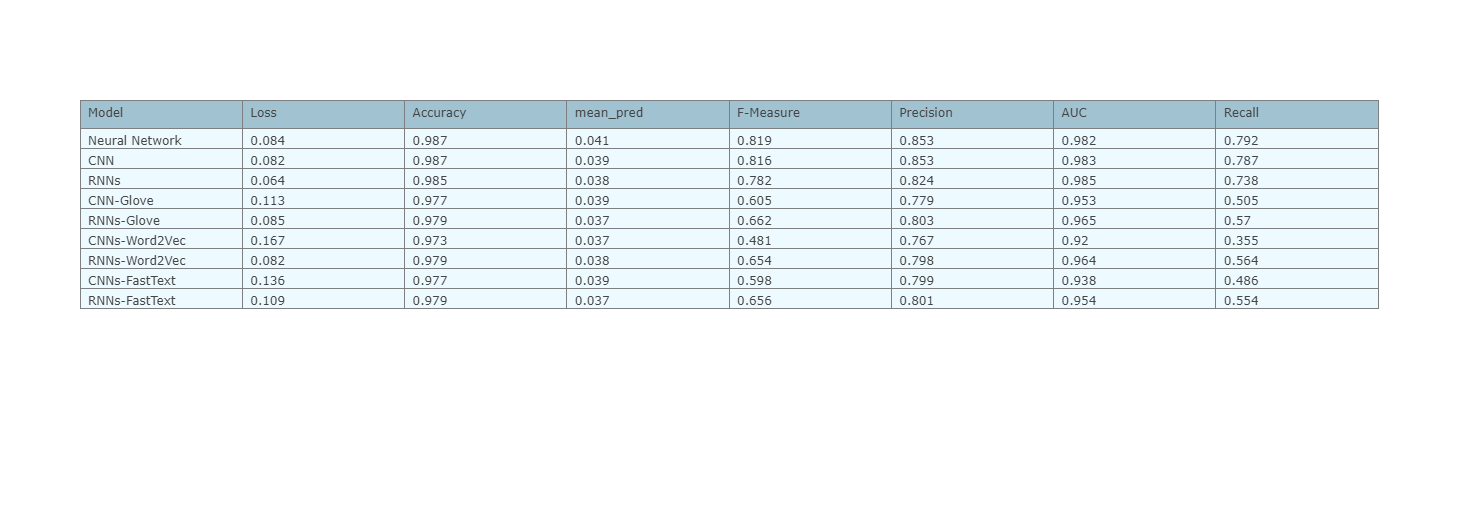

In [0]:
Image('multi-label_with the max of the evaluation matrics (per model) _table.png')

In [0]:
trace = go.Table(
    header=dict(values=['Model', 'Loss', 'Accuracy', 'mean_pred', 'F-Measure', 'Precision', 'AUC', 'Recall'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['left'] * 5),
    cells=dict(values=[['Neural Network', 'CNN', 'RNNs', 'CNN-Glove', 'RNNs-Glove', 'CNNs-Word2Vec', 'RNNs-Word2Vec', 'CNNs-FastText', 'RNNs-FastText'],
                       [
                        #Loss Evaluation
                        round(np.mean(nn_model_fit.history['loss']), 3), round(np.mean(CNN_model_fit.history['loss']), 3), round(np.mean(RNN_model_fit.history['loss']), 3), 
                        round(np.mean(CNN_Glove_model_fit.history['loss']), 3), round(np.mean(RNN_Glove_model_fit.history['loss']), 3), round(np.mean(CNN_Word2Vec_model_fit.history['loss']), 3),
                        round(np.mean(RNN_Word2Vec_model_fit.history['loss']), 3), round(np.mean(CNN_FastText_model_fit.history['loss']), 3), round(np.mean(RNN_FastText_model_fit.history['loss']), 3)],
                        
                        #Accuracy Evaluation
                        [round(np.mean(nn_model_fit.history['acc']), 3), round(np.mean(CNN_model_fit.history['acc']), 3), round(np.mean(RNN_model_fit.history['acc']), 3), 
                        round(np.mean(CNN_Glove_model_fit.history['acc']), 3), round(np.mean(RNN_Glove_model_fit.history['acc']), 3), round(np.mean(CNN_Word2Vec_model_fit.history['acc']), 3), 
                        round(np.mean(RNN_Word2Vec_model_fit.history['acc']), 3), round(np.mean(CNN_FastText_model_fit.history['acc']), 3), round(np.mean(RNN_FastText_model_fit.history['acc']), 3)],
               
                        #mean_pred Evaluation
                        [round(np.mean(nn_model_fit.history['mean_pred']), 3), round(np.mean(CNN_model_fit.history['mean_pred']), 3), round(np.mean(RNN_model_fit.history['mean_pred']), 3), 
                        round(np.mean(CNN_Glove_model_fit.history['mean_pred']), 3), round(np.mean(RNN_Glove_model_fit.history['mean_pred']), 3), round(np.mean(CNN_Word2Vec_model_fit.history['mean_pred']), 3), 
                        round(np.mean(RNN_Word2Vec_model_fit.history['mean_pred']), 3), round(np.mean(CNN_FastText_model_fit.history['mean_pred']), 3), round(np.mean(RNN_FastText_model_fit.history['mean_pred']),3)],
               
                        #F1-Measure Evaluation
                        [round(np.mean(nn_model_fit.history['fmeasure']), 3), round(np.mean(CNN_model_fit.history['fmeasure']), 3), round(np.mean(RNN_model_fit.history['fmeasure']), 3), 
                        round(np.mean(CNN_Glove_model_fit.history['fmeasure']), 3), round(np.mean(RNN_Glove_model_fit.history['fmeasure']), 3), round(np.mean(CNN_Word2Vec_model_fit.history['fmeasure']), 3), 
                        round(np.mean(RNN_Word2Vec_model_fit.history['fmeasure']), 3), round(np.mean(CNN_FastText_model_fit.history['fmeasure']), 3), round(np.mean(RNN_FastText_model_fit.history['fmeasure']), 3)],
               
                        #Precision Evaluation
                        [round(np.mean(nn_model_fit.history['precision']), 3), round(np.mean(CNN_model_fit.history['precision']), 3), round(np.mean(RNN_model_fit.history['precision']), 3), 
                        round(np.mean(CNN_Glove_model_fit.history['precision']), 3), round(np.mean(RNN_Glove_model_fit.history['precision']), 3), round(np.mean(CNN_Word2Vec_model_fit.history['precision']), 3), 
                        round(np.mean(RNN_Word2Vec_model_fit.history['precision']), 3), round(np.mean(CNN_FastText_model_fit.history['precision']), 3), round(np.mean(RNN_FastText_model_fit.history['precision']), 3)],
                        
                        #ROC AUC Evaluation
                        [round(np.mean(nn_model_fit.history['auroc']), 3), round(np.mean(CNN_model_fit.history['auroc']), 3), round(np.mean(RNN_model_fit.history['auroc']), 3), 
                        round(np.mean(CNN_Glove_model_fit.history['auroc']), 3), round(np.mean(RNN_Glove_model_fit.history['auroc']), 3), round(np.mean(CNN_Word2Vec_model_fit.history['auroc']), 3), 
                        round(np.mean(RNN_Word2Vec_model_fit.history['auroc']), 3), round(np.mean(CNN_FastText_model_fit.history['auroc']), 3), round(np.mean(RNN_FastText_model_fit.history['auroc']), 3)],
                       
                        #Recall Evaluation
                        [round(np.mean(nn_model_fit.history['recall']), 3), round(np.mean(CNN_model_fit.history['recall']), 3), round(np.mean(RNN_model_fit.history['recall']), 3), 
                        round(np.mean(CNN_Glove_model_fit.history['recall']), 3), round(np.mean(RNN_Glove_model_fit.history['recall']), 3), round(np.mean(CNN_Word2Vec_model_fit.history['recall']), 3), 
                        round(np.mean(RNN_Word2Vec_model_fit.history['recall']), 3), round(np.mean(CNN_FastText_model_fit.history['recall']), 3), round(np.mean(RNN_FastText_model_fit.history['recall']), 3)]
                       ],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['left'] * 5))

layout = dict(width=800, height=400)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(data, filename = 'multi-label_with the mean average of the evaluation matrics (per model) _table')

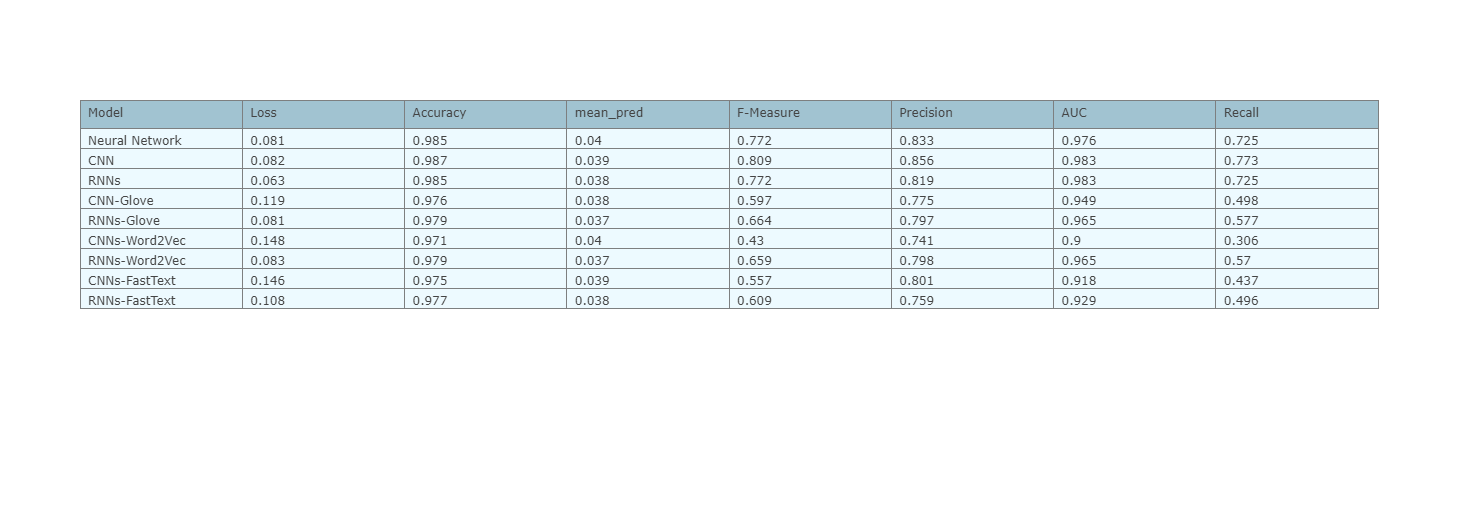

In [0]:
Image('multi-label_with the mean average of the evaluation matrics (per model) _table.png')

In [0]:
# concat all training, validation and testing accuracy scores
NN_Accuracy = ['Neural Network', 
               np.mean(nn_model_fit.history['acc']), 
               np.mean(nn_model_fit.history['val_acc']), 
               nn_test_score[1]]

CNN_Accuracy = ['Convolutional Neural Network (CNN)', 
                np.mean(CNN_model_fit.history['acc']), 
                np.mean(CNN_model_fit.history['val_acc']), 
                CNN_test_score[1]]

RNN_Accuracy = ['Recurrent Neural Networks (RNNs)', 
                np.mean(RNN_model_fit.history['acc']), 
                np.mean(RNN_model_fit.history['val_acc']), 
                RNN_test_score[1]]

CNN_Glove_Accuracy = ['Convolutional Neural Network (CNN) with Glove', 
                  np.mean(CNN_Glove_model_fit.history['acc']), 
                  np.mean(CNN_Glove_model_fit.history['val_acc']), 
                  CNN_Glove_test_score[1]]

RNN_Glove_Accuracy = ['Recurrent Neural Networks (RNNs) with Glove', 
                    np.mean(RNN_Glove_model_fit.history['acc']), 
                    np.mean(RNN_Glove_model_fit.history['val_acc']), 
                    RNN_Glove_test_score[1]]

CNN_Word2Vec_Accuracy = ['Convolutional Neural Networks (CNNs) with Word2Vec', 
                    np.mean(CNN_Word2Vec_model_fit.history['acc']), 
                    np.mean(CNN_Word2Vec_model_fit.history['val_acc']), 
                    CNN_Word2Vec_test_score[1]]

RNN_Word2Vec_Accuracy = ['Recurrent Neural Networks (RNNs) with Word2Vec', 
                    np.mean(RNN_Word2Vec_model_fit.history['acc']), 
                    np.mean(RNN_Word2Vec_model_fit.history['val_acc']), 
                    RNN_Word2Vec_test_score[1]]

CNN_FastText_Accuracy = ['Convolutional Neural Networks (RNNs) with FastText', 
                    np.mean(CNN_FastText_model_fit.history['acc']), 
                    np.mean(CNN_FastText_model_fit.history['val_acc']), 
                    RNN_Word2Vec_test_score[1]]


RNN_FastText_Accuracy = ['Recurrent Neural Networks (RNNs) with FastText', 
                    np.mean(RNN_FastText_model_fit.history['acc']), 
                    np.mean(RNN_FastText_model_fit.history['val_acc']), 
                    RNN_Word2Vec_test_score[1]]


# create dataframe
experimentalResult = pd.DataFrame([NN_Accuracy])
# append all other scores
experimentalResult = experimentalResult.append([CNN_Accuracy, RNN_Accuracy, CNN_Glove_Accuracy, RNN_Glove_Accuracy, CNN_Word2Vec_Accuracy, 
                                                RNN_Word2Vec_Accuracy, CNN_FastText_Accuracy, RNN_FastText_Accuracy])


# beautify the new dataframe
experimentalResult.columns = ['Model', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
experimentalResult.set_index(['Model'], inplace=True)
experimentalResult
print(experimentalResult)

                                                    Training Accuracy  \
Model                                                                   
Neural Network                                               0.983193   
Convolutional Neural Network (CNN)                           0.983788   
Recurrent Neural Networks (RNNs)                             0.983803   
Convolutional Neural Network (CNN) with Glove                0.974782   
Recurrent Neural Networks (RNNs) with Glove                  0.978010   
Convolutional Neural Networks (CNNs) with Word2Vec           0.971355   
Recurrent Neural Networks (RNNs) with Word2Vec               0.977359   
Convolutional Neural Networks (RNNs) with FastText           0.974756   
Recurrent Neural Networks (RNNs) with FastText               0.977612   

                                                    Validation Accuracy  \
Model                                                                     
Neural Network                                